In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Mount drive if you want to save the model
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os

# ✅ Set your dataset path here
DATASET_PATH = '/content/drive/MyDrive/lung-cancer-histopathological-images/lung_colon_image_set/lung_image_sets'

# --- Check existence ---
if not os.path.exists(DATASET_PATH):
    raise SystemExit("❌ Dataset path not found. Check the folder path carefully.")

# --- List classes ---
classes = [d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))]
print("✅ Classes found:", classes)

# --- Count images per class ---
for c in classes:
    p = os.path.join(DATASET_PATH, c)
    count = sum([1 for f in os.listdir(p) if os.path.isfile(os.path.join(p,f))])
    print(f"  {c:30s} : {count} files")


Mounted at /content/drive
✅ Classes found: ['lung_aca', 'lung_n', 'lung_scc']
  lung_aca                       : 3000 files
  lung_n                         : 3000 files
  lung_scc                       : 3000 files


In [5]:
# --- Install stable TF version (if not already) ---
!pip install -q tensorflow==2.13.0 tensorflow-addons

# --- Imports ---
import os, math, random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import VGG16
from sklearn.metrics import classification_report, confusion_matrix

# --- Check GPU ---
print("TensorFlow version:", tf.__version__)
device_name = tf.config.list_physical_devices('GPU')
print("GPU available:", bool(device_name))
if not device_name:
    print("⚠️ WARNING: GPU not detected. Go to 'Runtime > Change runtime type > GPU' before training.")


ERROR: Could not find a version that satisfies the requirement tensorflow==2.13.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.13.0
TensorFlow version: 2.19.0
GPU available: True


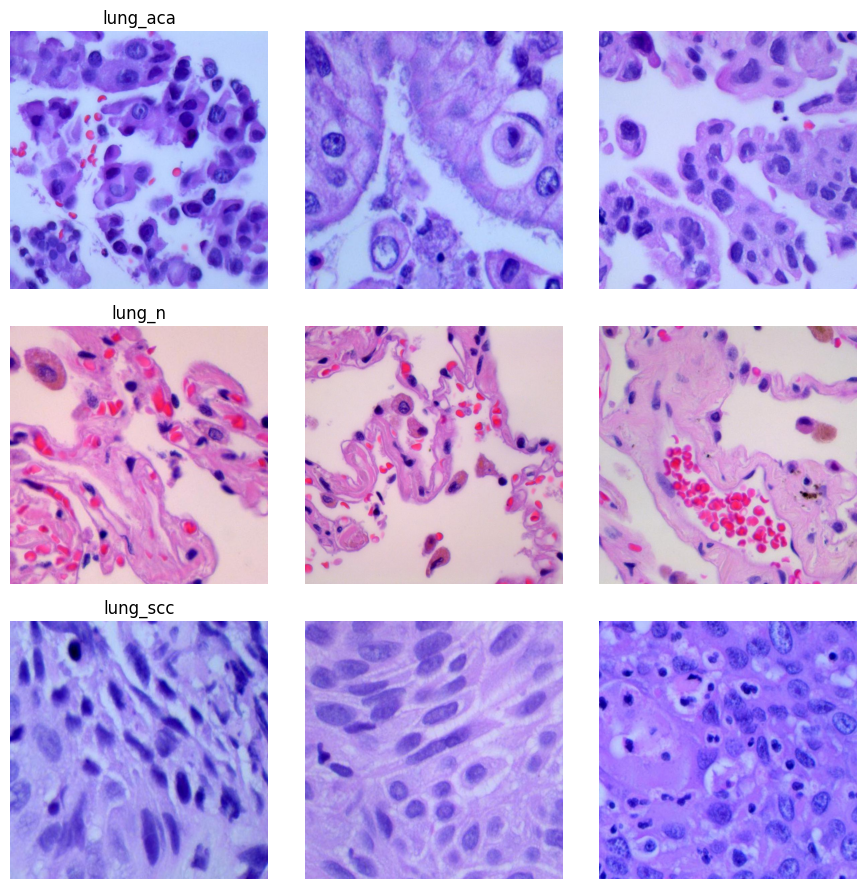

In [6]:
import matplotlib.pyplot as plt
import random
from PIL import Image

DATASET_PATH = '/content/drive/MyDrive/lung-cancer-histopathological-images/lung_colon_image_set/lung_image_sets'
classes = ['lung_aca', 'lung_n', 'lung_scc']  # in order

def show_samples(path, classes, per_class=3):
    fig, axes = plt.subplots(len(classes), per_class, figsize=(per_class*3, len(classes)*3))
    for i, c in enumerate(classes):
        imgs = [f for f in os.listdir(os.path.join(path, c)) if f.lower().endswith(('.png','.jpg','.jpeg'))]
        sample = random.sample(imgs, min(per_class, len(imgs)))
        for j, fn in enumerate(sample):
            img = Image.open(os.path.join(path, c, fn)).convert('RGB')
            axes[i,j].imshow(img)
            axes[i,j].axis('off')
            if j==0:
                axes[i,j].set_title(c)
    plt.tight_layout()
    plt.show()

show_samples(DATASET_PATH, classes, per_class=3)


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=SEED
)

val_gen = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=SEED
)

print("\n✅ Train samples:", train_gen.samples)
print("✅ Validation samples:", val_gen.samples)
print("✅ Class indices:", train_gen.class_indices)


Found 7200 images belonging to 3 classes.
Found 1800 images belonging to 3 classes.

✅ Train samples: 7200
✅ Validation samples: 1800
✅ Class indices: {'lung_aca': 0, 'lung_n': 1, 'lung_scc': 2}


In [8]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers

# Load pretrained VGG16 (exclude top classification layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # freeze base layers for now

# Build custom classifier head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(3, activation='softmax')  # 3 classes
])

# Compile model
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,978,883 (57.14 MB)

 Trainable params: 264,195 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint(
    'best_vgg16_baseline.h5', monitor='val_accuracy', mode='max',
    save_best_only=True, verbose=1
)

early_stop = EarlyStopping(
    monitor='val_accuracy', patience=5,
    restore_best_weights=True, verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3,
    verbose=1, min_lr=1e-7
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[checkpoint, early_stop, reduce_lr]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.5957 - loss: 0.8758 
Epoch 1: val_accuracy improved from -inf to 0.91000, saving model to best_vgg16_baseline.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 3855s 17s/step - accuracy: 0.5963 - loss: 0.8750 - val_accuracy: 0.9100 - val_loss: 0.4164 - learning_rate: 1.0000e-04
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.8824 - loss: 0.3951
Epoch 2: val_accuracy improved from 0.91000 to 0.92111, saving model to best_vgg16_baseline.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 164s 727ms/step - accuracy: 0.8824 - loss: 0.3949 - val_accuracy: 0.9211 - val_loss: 0.2847 - learning_rate: 1.0000e-04
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.9125 - loss: 0.2825
Epoch 3: val_accuracy improved from 0.92111 to 0.92278, saving model to best_vgg16_baseline.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 169s 749ms/step - accuracy: 0.9125 - loss: 0.2824 - val_accuracy: 0.9228 - val_loss: 0.2332 - learning_rate: 1.0000e-04
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.9236 - loss: 0.2341
Epoch 4: val_accuracy improved from 0.92278 to 0.93667, saving model to best_vgg16_baseline.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 166s 739ms/step - accuracy: 0.9236 - loss: 0.2340 - val_accuracy: 0.9367 - val_loss: 0.1970 - learning_rate: 1.0000e-04
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - accuracy: 0.9368 - loss: 0.1975
Epoch 5: val_accuracy did not improve from 0.93667
225/225 ━━━━━━━━━━━━━━━━━━━━ 167s 741ms/step - accuracy: 0.9368 - loss: 0.1975 - val_accuracy: 0.9339 - val_loss: 0.1842 - learning_rate: 1.0000e-04
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.9380 - loss: 0.1833
Epoch 6: val_accuracy did not improve from 0.93667
225/225 ━━━━━━━━━━━━━━━━━━━━ 163s 724ms/step - accuracy: 0.9380 - loss: 0.1833 - val_accuracy: 0.9311 - val_loss: 0.1745 - learning_rate: 1.0000e-04
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.9358 - loss: 0.1770
Epoch 7: val_accuracy improved from 0.93667 to 0.94444, saving model to best_vgg16_baseline.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 164s 731ms/step - accuracy: 0.9359 - loss: 0.1769 - val_accuracy: 0.9444 - val_loss: 0.1638 - learning_rate: 1.0000e-04
Epoch 8/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.9425 - loss: 0.1628
Epoch 8: val_accuracy did not improve from 0.94444
225/225 ━━━━━━━━━━━━━━━━━━━━ 162s 721ms/step - accuracy: 0.9425 - loss: 0.1628 - val_accuracy: 0.9444 - val_loss: 0.1511 - learning_rate: 1.0000e-04
Epoch 9/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.9498 - loss: 0.1498
Epoch 9: val_accuracy improved from 0.94444 to 0.94833, saving model to best_vgg16_baseline.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 167s 739ms/step - accuracy: 0.9498 - loss: 0.1498 - val_accuracy: 0.9483 - val_loss: 0.1464 - learning_rate: 1.0000e-04
Epoch 10/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.9528 - loss: 0.1358
Epoch 10: val_accuracy improved from 0.94833 to 0.94889, saving model to best_vgg16_baseline.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 164s 727ms/step - accuracy: 0.9528 - loss: 0.1358 - val_accuracy: 0.9489 - val_loss: 0.1374 - learning_rate: 1.0000e-04
Epoch 11/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.9480 - loss: 0.1386
Epoch 11: val_accuracy improved from 0.94889 to 0.95111, saving model to best_vgg16_baseline.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 168s 747ms/step - accuracy: 0.9480 - loss: 0.1386 - val_accuracy: 0.9511 - val_loss: 0.1313 - learning_rate: 1.0000e-04
Epoch 12/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.9533 - loss: 0.1348
Epoch 12: val_accuracy improved from 0.95111 to 0.95278, saving model to best_vgg16_baseline.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 201s 745ms/step - accuracy: 0.9532 - loss: 0.1348 - val_accuracy: 0.9528 - val_loss: 0.1364 - learning_rate: 1.0000e-04
Epoch 13/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.9553 - loss: 0.1307
Epoch 13: val_accuracy did not improve from 0.95278
225/225 ━━━━━━━━━━━━━━━━━━━━ 165s 733ms/step - accuracy: 0.9553 - loss: 0.1307 - val_accuracy: 0.9467 - val_loss: 0.1241 - learning_rate: 1.0000e-04
Epoch 14/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.9518 - loss: 0.1280
Epoch 14: val_accuracy did not improve from 0.95278
225/225 ━━━━━━━━━━━━━━━━━━━━ 164s 728ms/step - accuracy: 0.9518 - loss: 0.1280 - val_accuracy: 0.9522 - val_loss: 0.1313 - learning_rate: 1.0000e-04
Epoch 15/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.9494 - loss: 0.1282
Epoch 15: val_accuracy did not improve from 0.95278
225/225 ━━━━━━━━━━━━━━━━━━━━ 167s 739ms/step - accuracy: 0.9495 - loss: 0.1282 - val_accuracy: 0.9511 - val_loss: 0.1306 - learnin

In [10]:
from tensorflow.keras.models import load_model

# Load your best-performing model
model = load_model("best_vgg16_baseline.h5")

print("✅ Model loaded successfully.")


✅ Model loaded successfully.


In [12]:
val_loss, val_acc = model.evaluate(val_gen)
print(f"\n📊 Validation Accuracy: {val_acc*100:.2f}%")
print(f"📉 Validation Loss: {val_loss:.4f}")


57/57 ━━━━━━━━━━━━━━━━━━━━ 34s 573ms/step - accuracy: 0.9493 - loss: 0.1379

📊 Validation Accuracy: 95.06%
📉 Validation Loss: 0.1349


57/57 ━━━━━━━━━━━━━━━━━━━━ 37s 626ms/step


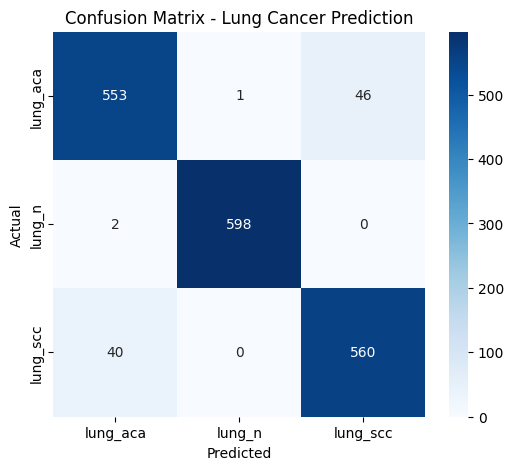

In [13]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict classes
y_pred = model.predict(val_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_gen.classes

# Get class labels
class_labels = list(val_gen.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Lung Cancer Prediction")
plt.show()


In [14]:
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))



Classification Report:

              precision    recall  f1-score   support

    lung_aca       0.93      0.92      0.93       600
      lung_n       1.00      1.00      1.00       600
    lung_scc       0.92      0.93      0.93       600

    accuracy                           0.95      1800
   macro avg       0.95      0.95      0.95      1800
weighted avg       0.95      0.95      0.95      1800



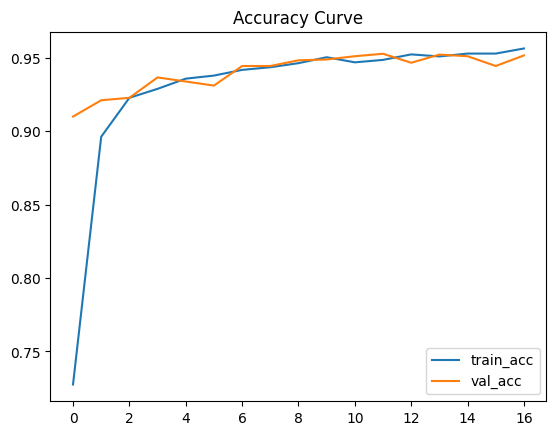

In [15]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title('Accuracy Curve')
plt.show()


In [17]:
model.save("lung_cancer_vgg16.keras")


In [18]:
from google.colab import files
files.download('best_vgg16_baseline.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
model.save("final_vgg16_model.keras")   # Save in the new safe format


In [20]:
from google.colab import files
files.download("final_vgg16_model.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
from tensorflow.keras.models import Model

# If you used transfer learning
# and your base model was VGG16 or similar:
model.summary()  # optional sanity check

# Ensure model is not wrapped inside Sequential wrongly
model.save("final_vgg16_model_fixed.keras", include_optimizer=False)
print("✅ Model saved cleanly")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,978,885 (57.14 MB)

 Trainable params: 264,195 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 2 (12.00 B)

✅ Model saved cleanly


In [22]:
from google.colab import files
files.download("final_vgg16_model_fixed.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
from tensorflow.keras.models import load_model

model = load_model("final_vgg16_model_fixed.keras", compile=False)


In [53]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = "/content/drive/MyDrive/lung-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_aca/lungaca1.jpeg"  # put your test image here

# Your model was likely trained on 224x224 input (VGG16 default)
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # (1, 224, 224, 3)
img_array = img_array / 255.0  # same normalization as training


In [54]:
pred = model.predict(img_array)
print(pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
[[0.790641   0.00081978 0.20853917]]


In [55]:
pred = model.predict(img_array)
CLASS_NAMES = [
    "Lung Adenocarcinoma",
    "Lung Normal (Benign Tissue)",
    "Lung Squamous Cell Carcinoma"
]

predicted_class = CLASS_NAMES[np.argmax(pred)]
confidence = np.max(pred) * 100

print(f"Predicted: {predicted_class} ({confidence:.2f}%)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted: Lung Adenocarcinoma (79.06%)


In [56]:
pred = model.predict(img_array)
cancer_confidence = pred[0][0] + pred[0][2]   # sum of adenocarcinoma + squamous
normal_confidence = pred[0][1]

if cancer_confidence > normal_confidence:
    print(f"Predicted: Cancer ({cancer_confidence*100:.2f}%)")
else:
    print(f"Predicted: Normal ({normal_confidence*100:.2f}%)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Predicted: Cancer (99.92%)
